In [2]:
import uproot
import h5py
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
from scipy import optimize
from collections import defaultdict

In [3]:
# def printattr(name, object):
#     print(name)
# h5py_file = h5py.File('h5files_w_klfitter/ttbar_testing_170_gev_with_spanet_KLFitter.h5', "r")
# h5py_file.visititems(printattr)

In [4]:
# Fixed the bins, colors, and tot_event for all plots.
bins = np.arange(100, 301, 2)
bins_dense = np.linspace(100, 300, 1000)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
mass = [173]
top_mass_dense = np.linspace(170, 176, 1000)
JSF_arr = [1]
JSF_dense = np.linspace(0.97, 1.03, 100)
state_labels = ['Unmatched', 'Incorrect', 'Correct']
lan_gau_fit_labels = ['Mean of Landau', 'Variance of Landau', 'Mean of Gaussian', 'Variance of Gaussian', 'Fraction of Gaussian']

In [5]:
def get_reco_top_mass(h5py_file, target, JSF): # Target is spanet or klfitter
    dic = {}

    #Load pt, eta, phi, and mass from file. Where q1, q2 and b are the index.
    q1 = np.array([[i] for i in h5py_file[target + '/right_target/q1'][:]])
    dic['q1_pt'] = np.take_along_axis(h5py_file['jet_features/pt'][:], q1, axis=1).flatten()
    dic['q1_eta'] = np.take_along_axis(h5py_file['jet_features/eta'][:], q1, axis=1).flatten()
    dic['q1_phi'] = np.take_along_axis(h5py_file['jet_features/phi'][:], q1, axis=1).flatten()
    dic['q1_mass'] = np.take_along_axis(h5py_file['jet_features/mass'][:], q1, axis=1).flatten()

    q2 = np.array([[i] for i in h5py_file[target + '/right_target/q2'][:]])
    dic['q2_pt'] = np.take_along_axis(h5py_file['jet_features/pt'][:], q2, axis=1).flatten()
    dic['q2_eta'] = np.take_along_axis(h5py_file['jet_features/eta'][:], q2, axis=1).flatten()
    dic['q2_phi'] = np.take_along_axis(h5py_file['jet_features/phi'][:], q2, axis=1).flatten()
    dic['q2_mass'] = np.take_along_axis(h5py_file['jet_features/mass'][:], q2, axis=1).flatten()

    b = np.array([[i] for i in h5py_file[target + '/right_target/b'][:]])
    dic['b_pt'] = np.take_along_axis(h5py_file['jet_features/pt'][:], b, axis=1).flatten()
    dic['b_eta'] = np.take_along_axis(h5py_file['jet_features/eta'][:], b, axis=1).flatten()
    dic['b_phi'] = np.take_along_axis(h5py_file['jet_features/phi'][:], b, axis=1).flatten()
    dic['b_mass'] = np.take_along_axis(h5py_file['jet_features/mass'][:], b, axis=1).flatten()
    
    # px = pt*cos(phi)
    # py = pt*sin(phi)
    # pz = pt*sinh(eta)
    # E  = sqrt(m**2 + px**2 + py**2 + pz**2)*JSF
    dic['px1'] = dic['q1_pt']*np.cos(dic['q1_phi'])
    dic['py1'] = dic['q1_pt']*np.sin(dic['q1_phi'])
    dic['pz1'] = dic['q1_pt']*np.sinh(dic['q1_eta'])
    dic['E1'] = np.sqrt(dic['q1_mass']**2+dic['px1']**2+dic['py1']**2+dic['pz1']**2)*JSF

    dic['px2'] = dic['q2_pt']*np.cos(dic['q2_phi'])
    dic['py2'] = dic['q2_pt']*np.sin(dic['q2_phi'])
    dic['pz2'] = dic['q2_pt']*np.sinh(dic['q2_eta'])
    dic['E2'] = np.sqrt(dic['q2_mass']**2+dic['px2']**2+dic['py2']**2+dic['pz2']**2)*JSF

    dic['bx'] = dic['b_pt']*np.cos(dic['b_phi'])
    dic['by'] = dic['b_pt']*np.sin(dic['b_phi'])
    dic['bz'] = dic['b_pt']*np.sinh(dic['b_eta'])
    dic['bE'] = np.sqrt(dic['b_mass']**2+dic['bx']**2+dic['by']**2+dic['bz']**2)*JSF
    
    # M = sqrt((m1+m2)**2 + (px1+px2)**2 + (py1+py2)**2 + (pz1+pz2)**2)
    dic['reconstructed_top_mass'] = np.sqrt((dic['E1']+dic['E2']+dic['bE'])**2
                    - (dic['px1']+dic['px2']+dic['bx'])**2
                    - (dic['py1']+dic['py2']+dic['by'])**2
                    - (dic['pz1']+dic['pz2']+dic['bz'])**2)

    """
    cuts
    100 < reco_m_top < 300
    additional cuts (same as CMS)
    """
    # Caululate delR
    lepton_eta = h5py_file['lepton_features/eta'][:]
    lepton_phi = h5py_file['lepton_features/phi'][:]
    jet_eta = h5py_file['jet_features/eta'][:]
    jet_phi = h5py_file['jet_features/phi'][:]
    del_eta = np.array([jet_eta[i, :4] - lepton_eta[i] for i in range(len(jet_eta))])
    del_phi = np.abs([jet_phi[i, :4] - lepton_phi[i] for i in range(len(jet_eta))])
    del_phi = np.where(del_phi < np.pi, del_phi, 2*np.pi-del_phi)
    delR = np.sqrt(del_eta**2 + del_phi**2)

    # cuts
    # pid 11 is electron, 13 is muon.
    cut_reco_top = np.logical_and(dic['reconstructed_top_mass'] > 100, dic['reconstructed_top_mass'] < 300)
    cut_lepton_pt = np.logical_or(
                        np.logical_and(h5py_file['lepton_features/pt'][:] > 26, h5py_file['lepton_features/pid'][:] == 13),
                        np.logical_and(h5py_file['lepton_features/pt'][:] > 29, h5py_file['lepton_features/pid'][:] == 11))
    cut_lepton_eta = np.abs(h5py_file['lepton_features/eta'][:]) < 2.4
    cut_delR = np.logical_or(np.logical_and.reduce((h5py_file['lepton_features/pid'][:] == 13, delR[:, 0] > 0.4, delR[:, 1] > 0.4, delR[:, 2] > 0.4, delR[:, 3] > 0.4)),
            np.logical_and.reduce((h5py_file['lepton_features/pid'][:] == 11, delR[:, 0] > 0.3, delR[:, 1] > 0.3, delR[:, 2] > 0.3, delR[:, 3] > 0.3)))
    cut_jet_pt = h5py_file['jet_features/pt'][:, 3] > 30
    cut_jet_eta = np.logical_and.reduce((abs(h5py_file['jet_features/eta'][:, 0]) < 2.4, abs(h5py_file['jet_features/eta'][:, 1]) < 2.4,
                                        abs(h5py_file['jet_features/eta'][:, 2]) < 2.4, abs(h5py_file['jet_features/eta'][:, 3]) < 2.4))
    cut_first4_btag = np.sum(h5py_file['jet_features/btag'][:, :4], axis=1) == 2
    cuts = np.logical_and.reduce((cut_reco_top, cut_lepton_pt, cut_lepton_eta, cut_delR, cut_jet_pt, cut_jet_eta, cut_first4_btag))

    # Check the state of the event.
    state = [1]*len(h5py_file['target/right_target/q1'][:])

    # Two permutations for q1 and q2.
    a = np.logical_and(h5py_file['target/right_target/q1'][:] == h5py_file[target + '/right_target/q1'][:], 
                        h5py_file['target/right_target/q2'][:] == h5py_file[target + '/right_target/q2'][:])
    b = np.logical_and(h5py_file['target/right_target/q1'][:] == h5py_file[target + '/right_target/q2'][:], 
                        h5py_file['target/right_target/q2'][:] == h5py_file[target + '/right_target/q1'][:])
    a_or_b = np.logical_or(a, b)
    right = np.logical_and(a_or_b, h5py_file['target/right_target/b'][:] == h5py_file[target + '/right_target/b'][:])
    state = np.where(right, 2, state)

    # Check for unmatch
    unmatch = np.logical_or.reduce((h5py_file['target/right_target/q1'][:] == -1,
                        h5py_file['target/right_target/q2'][:] == -1,
                        h5py_file['target/right_target/b'][:] == -1))
    state = np.where(unmatch, 0, state)
    if target == 'klfitter': return dic['reconstructed_top_mass'], state, cuts, h5py_file['klfitter/score/loglikelihood'][:]
    elif target == 'spanet': return dic['reconstructed_top_mass'], state, cuts, h5py_file['spanet/right_target/assignment_probability'][:], h5py_file['spanet/right_target/detection_probability'][:], h5py_file['spanet/right_target/marginal_probability'][:]

In [6]:
# The reco_top_mss from ttbar_testing_mass_variation
# 0 for unmatched, 1 for incorrect, 2 for correct
reco_spanet_dic, state_spanet_dic, cut_spanet_dic = {}, {}, {}
reco_klf_dic, state_klf_dic, cut_klf_dic = {}, {}, {}
loglikeli_klf_dic, assignment_spanet_dic, detection_spanet_dic, marginal_spanet_dic = {}, {}, {}, {}

for m in mass:
    for JSF in JSF_arr:
        h5py_file = h5py.File('ttbar_testing/ttbar_testing_{}_gev.h5'.format(m), "r")
        reco_spanet_dic[(m, JSF)], state_spanet_dic[(m, JSF)], cut_spanet_dic[(m, JSF)], assignment_spanet_dic[(m, JSF)], detection_spanet_dic[(m, JSF)], marginal_spanet_dic[(m, JSF)] = get_reco_top_mass(h5py_file, 'spanet', JSF)
        h5py_file = h5py.File('h5files_w_klfitter/ttbar_testing_{}_gev_with_spanet_KLFitter.h5'.format(m), "r")
        reco_klf_dic[(m, JSF)], state_klf_dic[(m, JSF)], cut_klf_dic[(m, JSF)], loglikeli_klf_dic[(m, JSF)]  = get_reco_top_mass(h5py_file, 'klfitter', JSF)

In [14]:
marginal_cut_arr = np.linspace(0.1, 0.9, 1000)
marginal_event_number = []
marginal_correct_number = []
marginal_correct_ratio = []
for cut in marginal_cut_arr:
    correct = np.count_nonzero(np.logical_and.reduce((cut_klf_dic[(m, JSF)], state_klf_dic[(m, JSF)] == 2, marginal_spanet_dic[(m, JSF)]>cut)))
    total = np.count_nonzero(np.logical_and.reduce((cut_klf_dic[(m, JSF)], marginal_spanet_dic[(m, JSF)]>cut)))
    marginal_event_number.append(total)
    marginal_correct_number.append(correct)
    marginal_correct_ratio.append(correct/total)

loglikeli_cut_arr = np.linspace(-90, -60, 1000)
loglikeli_event_number = []
loglikeli_correct_number = []
loglikeli_correct_ratio = []
for cut in loglikeli_cut_arr:
    correct = np.count_nonzero(np.logical_and.reduce((cut_klf_dic[(m, JSF)], state_klf_dic[(m, JSF)] == 2, loglikeli_klf_dic[(m, JSF)]>cut)))
    total = np.count_nonzero(np.logical_and.reduce((cut_klf_dic[(m, JSF)], loglikeli_klf_dic[(m, JSF)]>cut)))
    loglikeli_event_number.append(total)
    loglikeli_correct_number.append(correct)
    loglikeli_correct_ratio.append(correct/total)

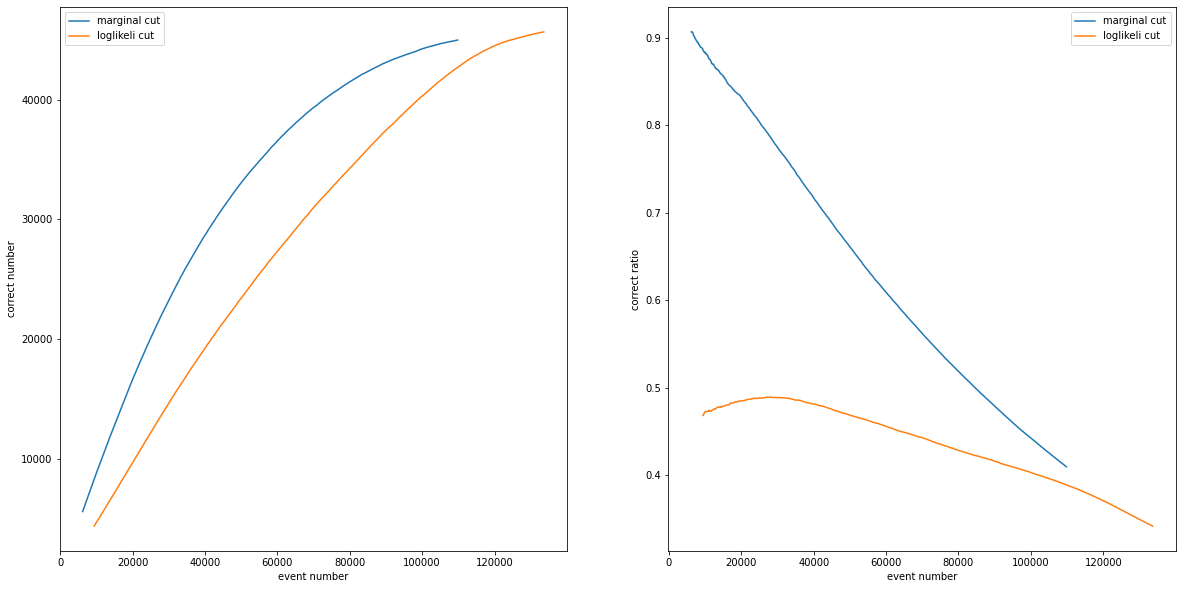

In [15]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(marginal_event_number, marginal_correct_number, label = 'marginal cut')
plt.plot(loglikeli_event_number, loglikeli_correct_number, label = 'loglikeli cut')
plt.xlabel('event number')
plt.ylabel('correct number')
plt.legend(loc = 'upper left')

plt.subplot(1, 2, 2)
plt.plot(marginal_event_number, marginal_correct_ratio, label = 'marginal cut')
plt.plot(loglikeli_event_number, loglikeli_correct_ratio, label = 'loglikeli cut')
plt.xlabel('event number')
plt.ylabel('correct ratio')
plt.legend(loc = 'upper right')
plt.show()